In [11]:
##################UCITAVANJE NEOPHODNIH BIBLIOTEKA###########
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
import random as rd
import math 
from bokeh.plotting import figure
from sklearn.decomposition import PCA
from sklearn.decomposition import PCA
import matplotlib
%matplotlib inline

In [12]:
###################CENTAR GRAVITACIJE#####################
def center_of_gravity(data):
    columns = []
    for col in data.columns:
        columns.append(data[col].values)

    center_of_gravity_array = []

    for i in columns:
        i_coordinate = sum(i) / len(i)
        center_of_gravity_array.append(i_coordinate)
    
    return center_of_gravity_array

In [13]:
#################INICIJALIZACIJA CENTARA###############
def center_initialization(data, num_of_clusters):

    center_array = []
    max_index_array = []
    random_center_index = rd.randint(0, len(data)-1)

    #dodaj index koji je uzet
    max_index_array.append(random_center_index)

    #biramo proizvoljnu tacku za centar
    center_array.append(data.ix[random_center_index].values)

    #num_of_clusters puta racunam tacke
    for i in range(0, num_of_clusters-1):

        distance_array_arrays = []
        #prvi put ce biti samo jedan, pa dva, pa tri itd
        for center in center_array:
            #za svaki centar racunam rastojanje od svih tacaka u skupu
            distance_array = []
            for index, row in data.iterrows():
                distance = 0
                point = data.ix[index].values
                for p in range(0, len(center)):
                    distance = distance + (point[p] - center[p]) * (point[p] - center[p])
                distance_array.append(distance) #za 1 centar dodaj rastojanje od tacke
            #dodaj sva rastojanja za 1 centar
            distance_array_arrays.append(distance_array)


        center = []
        for k in range(0, len(distance_array_arrays[0])):
            summ = 0
            for j in range(0, len(distance_array_arrays)):
                summ += distance_array_arrays[j][k]
            center.append(summ)

        #da se osiguramo da nece biti uzete dve iste tacke za centar
        while (1):
            #da uklonimo duplikate
            center = list(set(center))
            max_value = max(center)
            max_index = center.index(max_value)
            if (max_index not in max_index_array):
                max_index_array.append(max_index)
                center_array.append(data.ix[max_index].values)
                break
            else:
                center.remove(center[max_index])


    return center_array
        

In [14]:
##################GLAVNI DEO, EXPECTATION MAXIMIZATION ALGORITAM#################

def EM_procedure(num_of_clusters, data, beta, num_iterations, center_array, num_data, num_attributes):
    # inicijalizacija tzv "skrivene" matrice
    hidden_matrix = np.zeros([num_of_clusters, num_data])

    for param in range(0, num_iterations):

        data_points_array = []

        #########################KORAK od centara do klastera#############################
        for index, row in data.iterrows():

            #print ('Iteracija ' + str(index))
            # racunamo za svaku tacku rastojanje do svih centara
            point = data.ix[index].values

            # ispisi su za debagovanje
            #print ('Tacka: ' + str(point))

            point_center_distance_array = []
            data_points_array.append(point)

            for center in center_array:
                # prvo racunamo obicno rastojanje izmedju centra i tacke
                distance = 0
                for p in range(0, len(point)):
                    distance = distance + (point[p] - center[p]) * (point[p] - center[p])

                #print ('Centar ' + str(center) + ' rastojanje ' + str(p) + ' ' + str(point) + '=' + str(distance))

                # a zatim racunamo vrednost partition funkcije po kojoj formiramo skrivenu matricu
                partition_function = math.exp(math.sqrt(distance) * (-beta))

                #print ('Centar ' + str(center) + ' novo rastojanje ' + str(p) + ' ' + str(point) + '=' + str(partition_function))

                point_center_distance_array.append(partition_function)

            sum_point_center_distance = sum(point_center_distance_array)

            if (sum_point_center_distance == 0):
                print ('Sranje')
                print (index)
                print (sum_point_center_distance)

            # print ('Partition function' + str(point_center_distance_array))
            # print ('Sume rastojanja centara od tacke ' + str(sum_point_center_distance))

            for num_centers in range(0, num_of_clusters):
                hidden_matrix[num_centers, index] = point_center_distance_array[num_centers] / sum_point_center_distance
                # print ('Hidden matrix: ' + str(hidden_matrix))

        ####################KORAK od klastera do novih centara########################

        center_array = []
        new_coordinate_of_center_i = 0

        # print ('Tacke: ' + str(data_points_array))
        for i in range(0, num_of_clusters):
            new_center = []

            sum_of_i_row = sum(hidden_matrix[i])

            # racunanje novih koordinata centara na osnovu skrivene matrice
            for num_coord in range(0, num_attributes):
                new_coordinate_of_center_i = 0
                for dp in range(0, len(data_points_array)):
                    # print (str(hidden_matrix[i, dp]) + ' ' + str(data_points_array[dp][num_coord]))
                    new_coordinate_of_center_i += (hidden_matrix[i, dp] * data_points_array[dp][num_coord])

                new_coordinate_of_center_i = new_coordinate_of_center_i / sum_of_i_row
                new_center.append(new_coordinate_of_center_i)

            center_array.append(new_center)

            # print ('Novi centri' + str(center_array))

    return center_array, hidden_matrix, data_points_array

In [15]:
#####################DODELJIVANJE TACAKA KLASTERIMA###################

def cluster_creating(cols, data_points_array, hidden_matrix):
    # inicijalizacija klastera
    data_cluster = {}

    for i in range(0, len(hidden_matrix[0])):
        hidden_matrix_column = hidden_matrix[:, i]
        max_hidden_matrix_column = hidden_matrix_column.argmax()
        key = max_hidden_matrix_column
        if key in data_cluster.keys():
            data_cluster[key].append(data_points_array[i])
        else:
            data_cluster[key] = []
            data_cluster[key].append(data_points_array[i])

    dataframe = pd.DataFrame(list(data_cluster.items()), columns=['Center', 'Points'])

    ################FORMIRANJE NOVOG DATAFRAME-a SA INFORMACIJOM O KLASTERU

    new_dataframe = pd.DataFrame(columns=cols)

    index_data_points = -1

    for index, row in dataframe.iterrows():
        center = row.values[0]
        array_of_points = row.values[1]
        for i in array_of_points:
            index_data_points += 1
            for j in range(0, len(i)):
                point = []
                new_dataframe.set_value(index_data_points, cols[j], i[j])
                new_dataframe.set_value(index_data_points, 'cluster', center)

    return new_dataframe


In [16]:
#################PRIKAZIVANJE REZULTATA####################
def visualize(num_of_clusters, new_dataframe, cluster_column, num_attributes, cols):
    colors = matplotlib.cm.rainbow(np.linspace(0, 1, num_of_clusters))

    for index, row in new_dataframe.iterrows():
        point = new_dataframe.ix[index].values
        col = point[cluster_column]
        point = point[:-1]
        if (len(point) > 2):
            plt.plot(point, color=colors[col])
            # else:
            #   name = 'cluster #' + str(int(col))
            #  plt.plot(point, 0, color = colors[col], marker='o', markersize=10. label = name)
    plt.show()

    plt.style.use('ggplot')

    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_prop_cycle(color=colors)
    ax.margins(0.05)

    p = figure(x_axis_label='Component A', y_axis_label='Component B')

    if (num_attributes > 3):

        # redukcija dimenzionalnosti
        pca = PCA(n_components=2)
        pca.fit(new_dataframe[cols[:-1]].transpose())

        low_dimensional_frame = pd.DataFrame(pca.components_.T, columns=['component_a', 'component_b'])
        low_dimensional_frame['cluster'] = new_dataframe['cluster']

        for i in range(0, num_of_clusters):
            cluster_variable = low_dimensional_frame[low_dimensional_frame.cluster == i]
            p.circle(x=cluster_variable['component_a'], y=cluster_variable['component_b'], color=colors[i], size=10,
                     alpha=0.8)

        groups = low_dimensional_frame.groupby('cluster')

        for name, group in groups:
            name = 'cluster #' + str(int(name) + 1)
            ax.plot(group.component_a, group.component_b, marker='o', linestyle='', ms=12, label=name)
        ax.legend(numpoints=1, loc='upper left')

        plt.show()

    elif (num_attributes == 2):

        for i in range(0, num_of_clusters):
            cluster_variable = new_dataframe[new_dataframe.cluster == i]
            p.circle(x=cluster_variable[cols[0]], y=cluster_variable[cols[1]], color=colors[i], size=10, alpha=0.8)

        groups = new_dataframe.groupby('cluster')

        for name, group in groups:
            name = 'cluster #' + str(int(name) + 1)
            ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=name)
        ax.legend(numpoints=1, loc='upper left')

        plt.show()


[array([-0.28, -0.23, -0.19, -0.19, -0.32, -0.18, -0.18]), array([ 0.15,  0.15,  0.17,  0.09,  0.07,  0.09,  0.07]), array([-0.19, -0.15,  0.03,  0.27,  0.54,  3.64,  2.74])]


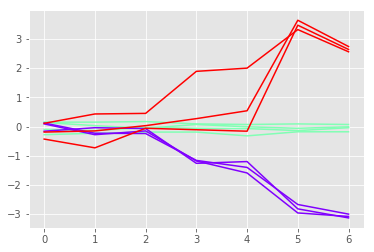

/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the s

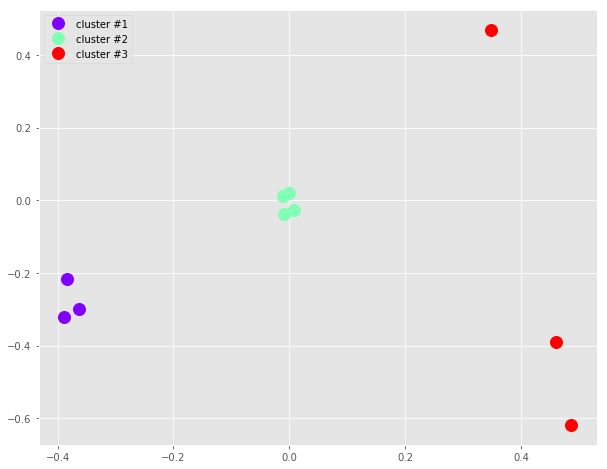

In [17]:
#################################GENI KVASCA############################

#broj klastera
num_of_clusters = 3

#broj iteracija
num_iterations = 200

#parametar beta
beta = 0.7

#ucitavamo .csv fajl sa genskim ekspresijama
#(samo ih je 10, radi lakse ilustracije i brzeg rada programa)

data_yeast = pd.read_csv('10_yeast_genes.csv', '\t')

#brisemo nedostajuce vrednosti
data_yeast = data_yeast.dropna()

#za posebne fajlove, kada je prva kolona npr identifikator gena,
#pa necemo da je uzimamo u obzir
#data = data[cols[1:]]
#data = data.reset_index(drop=True)

#odredjivanje dimenzija matrice, odnosno dataframe-a
shape = data_yeast.shape
num_attributes_yeast = shape[1]
num_data_yeast = shape[0]

#nazivi kolona i dodavanje nove kolone za klaster
cols_yeast = list(data_yeast)
cols_yeast.append('cluster')

#pozivi funkcija
center_array_yeast = center_initialization(data_yeast, num_of_clusters)
print(center_array_yeast)
center_array_yeast, hidden_matrix_yeast, data_points_array_yeast = EM_procedure(num_of_clusters, data_yeast, beta, num_iterations, center_array_yeast, num_data_yeast, num_attributes_yeast)
new_dataframe_yeast = cluster_creating(cols_yeast, data_points_array_yeast, hidden_matrix_yeast)
visualize(num_of_clusters, new_dataframe_yeast, 7, num_attributes_yeast, cols_yeast)

##################IZVOZ PODATAKA U .CSV FORMAT########
for i in reversed(range(0, num_of_clusters)):
    new_dataframe_yeast.loc[new_dataframe_yeast['cluster'] == i, 'cluster'] = i+1
new_dataframe_yeast.to_csv('yeast_gene_expression.csv', index = False)

########NECEMO DA NAM SE PRIKAZUJU CRVENI WARNING#########
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

[array([ 0.996,  0.   ]), array([ 1.821,  0.   ]), array([ 0.55,  0.  ])]


/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the s

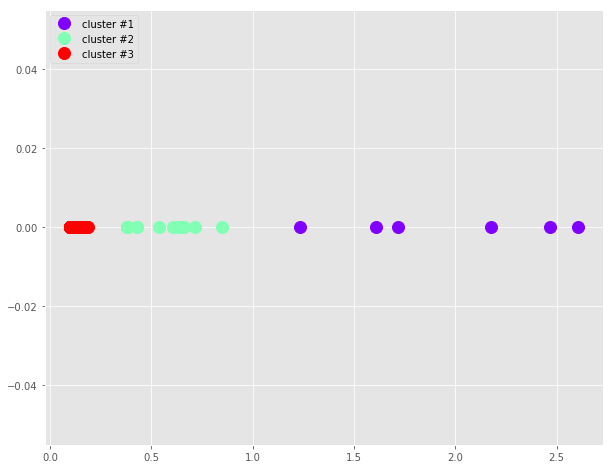

/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the same length", BokehUserWarning))
/Users/milicakojicic/anaconda/lib/python3.6/site-packages/bokeh/models/sources.py:81: BokehUserWarning: ColumnDataSource's columns must be of the same length
  lambda: warnings.warn("ColumnDataSource's columns must be of the s

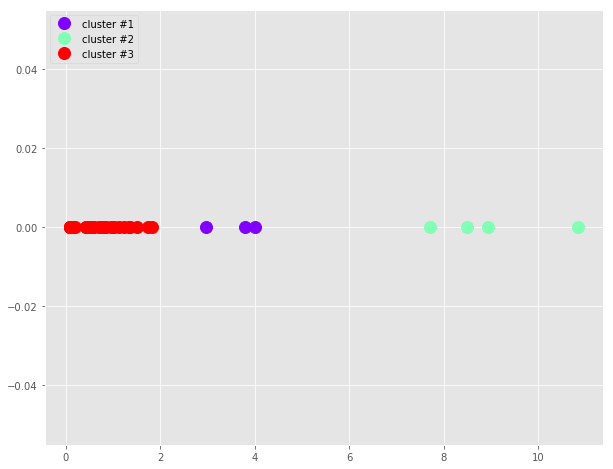

In [18]:
#########################TUMOR-NORMAL GENI - POTENCIJALNI BIOMARKERI##################

#broj klastera
num_of_clusters = 3

#broj iteracija
num_iterations = 1000

#parametar beta
beta = 3

#ucitavamo .csv fajl sa genskim ekspresijama
data_t_n = pd.read_csv('t_n_colon.csv/malo_gena.csv', ',')

#brisemo nedostajuce vrednosti
data_t_n  = data_t_n .dropna()

#za posebne fajlove, kada je prva kolona npr identifikator gena,
#pa necemo da je uzimamo u obzir
#data = data[cols[1:]]|
data_t_n = data_t_n.reset_index(drop=True)

data_tumor = pd.DataFrame(data_t_n['Intensity in Tumor'])
data_tumor.columns = ['x']
data_tumor['y'] = 0

data_normal = pd.DataFrame(data_t_n['Intensity in Normal'])
data_normal.columns = ['x']
data_normal['y'] = 0

#normalizacija podataka
data_tumor = data_tumor / 100
data_normal = data_normal / 100

shape_t_n = data_tumor.shape
num_attributes_t_n = shape_t_n[1]
num_data_t_n = shape_t_n[0]

#nazivi kolona
cols_tumor = list(data_tumor)
cols_tumor.append('cluster')

cols_normal = list(data_normal)
cols_normal.append('cluster')

######TUMOR KLASTER#####
center_array_tumor = center_initialization(data_tumor, num_of_clusters)
center_array_tumor, hidden_matrix_tumor, data_points_array_tumor = EM_procedure(num_of_clusters, data_tumor, beta, num_iterations, center_array_tumor, num_data_t_n, num_attributes_t_n)
new_dataframe_tumor = cluster_creating(cols_tumor, data_points_array_tumor, hidden_matrix_tumor)


######NORMAL KLASTER#####
center_array_normal = center_initialization(data_normal, num_of_clusters)
print (center_array_normal)
center_array_normal, hidden_matrix_normal, data_points_array_normal = EM_procedure(num_of_clusters, data_normal, beta, num_iterations, center_array_normal, num_data_t_n, num_attributes_t_n)
new_dataframe_normal = cluster_creating(cols_normal, data_points_array_normal, hidden_matrix_normal)


##############VIZUALIZACIJA I TUMORA I NORMALA################
visualize(num_of_clusters, new_dataframe_tumor, 1, num_attributes_t_n, cols_tumor)
visualize(num_of_clusters, new_dataframe_normal, 1, num_attributes_t_n, cols_normal)


##################IZVOZ PODATAKA U .CSV FORMAT########
del new_dataframe_tumor['y']
del new_dataframe_normal['y']

for i in reversed(range(0, num_of_clusters)):
    new_dataframe_tumor.loc[new_dataframe_tumor['cluster'] == i, 'cluster'] = i+1
new_dataframe_tumor.to_csv('tumor_gene_expression.csv', index = False)

for i in reversed(range(0, num_of_clusters)):
    new_dataframe_normal.loc[new_dataframe_normal['cluster'] == i, 'cluster'] = i+1
new_dataframe_normal.to_csv('normal_gene_expression.csv', index = False)


########NECEMO DA NAM SE PRIKAZUJU CRVENI WARNING#########
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')